# Introduction to SynthesisFilters.jl

This notebook demonstrates how [SyntheisFilters.jl](https://github.com/r9y9/SynthesisFilters.jl) works. Below we provide synthesized audio examples (Japanese) so that you are able to compare synthesis filters on your browser. Please read on.

In this notebook, the following synthesis fileters are demonstrated.

- **LMADF**: Log magnitude approximation digital filter for synthesis from cepstrum
- **MLSADF**: Mel-log spectrum approximation digital filter for synthesis from mel-cepstrum
- **MGLSADF**: Mel generalized-log spectrum approximation digital filter for synthesis from mel-generalized cepstrum
- **AllPoleDF**: All-pole digital filter for synthesis from LPC
- **AllPoleLatticeDF**: All-pole lattice digital filter for synthesis from PARCOR
- **LSPDF**: LSP digital filter for synthesis from LSP

### Related pacakges

- [MelGeneralizedCepstrums.jl](https://github.com/r9y9/MelGeneralizedCepstrums.jl): provides spectral parameter estimation based on mel-generalized cepstrum analysis.
- [SPTK.jl](https://github.com/r9y9/SPTK.jl): a thin wrapepr for SPTK
- [WORLD.jl](https://github.com/r9y9/WORLD.jl): a high-quality speech analysis, modification and synthesis system

In [1]:
using PyCall
matplotlib = pyimport("matplotlib")
PyDict(matplotlib["rcParams"])["figure.figsize"] = (12, 5)
using PyPlot

In [2]:
# https://gist.github.com/jfsantos/a39ed69a7894876f1e04#file-audiodisplay-jl
# Thanks, @jfsantos
include("AudioDisplay.jl")

inline_audioplayer (generic function with 2 methods)

In [3]:
using WAV
using DSP
using MelGeneralizedCepstrums # to esimate spectral envelope parameters
using SynthesisFilters

In [4]:
# plotting utilities
function wavplot(x; label="a waveform", x_label="sample")
    plot(1:endof(x), x, "b", label=label)
    xlim(1, endof(x))
    xlabel(x_label)
    legend()
end

function wavcompare(x, y; label="synthesized waveform", x_label="sample")
    plot(1:endof(y), y, "r-+", label=label)
    plot(1:endof(x), x, label="original speech signal")
    xlim(1, endof(x))
    xlabel(x_label)
    legend()
end

wavcompare (generic function with 1 method)

## Data

In this notebook, we use the follwoing audio data to analyze and re-synthesize. Let's see and listen the example.

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAmAD8AOQA/ADgAOwA4ADsAOQA6ADkAOAA3ADkANgA2ADYANgA2ADUAMgAxADIAMgAyADEAMQAwADEAMwAyADQAMgAwADAALwAuAC8ALQAqACkAKwAqACsALAArACoAKgAqACcAJwAnACYAJQAkACMAJQAkACUAIgAiACIAIAAkACEAIQAgACAAHwAeABoAGgAYABcAGAAUABIAEQAPAA0ADAAJAAgABQAIAAcABgAIAAUABAAEAAIAAAAAAAAAAAD///3/+//6//z//P/7//r/+//3//b/9//2//X/8f/z//L/8P/v/+//8P/v/+3/6//q/+n/6P/n/+f/5v/n/+P/5P/k/+L/4f/h/97/3f/e/93/3v/d/9z/2//Z/9j/2f/X/9b/1f/U/9P/0v/S/9P/0//R/8//zv/M/87/zf/N/83/zP/M/8z/y//L/83/zf/N/83/zP/O/8//zv/O/83/zv/P/8//zv/O/83/zv/L/8v/zP/N/8z/y//L/8n/yf/L/8j/x//I/8f/yP/H/8b/xv/H/8b/xv/F/8f/xf/G/8T/wv/B/8D/wv/C/8D/wP/A/7//v//A/7//wP+9/77/vv/A/7//wP/A/7//wf/B/8D/w//C/8H/wf/A/8D/wP/A/8D/wf/B/8H/w//C/8D/v/+//8H/v/+8/77/vP+7/7v/u/+7/7v/u/+5/7n/uP+5/7n/uf+7/7v/uv+6/7r/uv+3/7f/tv+3/7X/tv+5/7n/uP+4/7f/uP+5/7r/uP+4/7f/t/+1/7T/tf+0/7X/tP+z/7T/sv+z/7P/tP+x/7L/sf+w/7D/rv+v/67/rf+u/7D/sP+x/7H/sv+x/7H/s/+y/7T/tP+1/7f/t/+6/7v/uP+6/7j/uf+7/7r/vP+8/7z/vf+8/7z/v/+//8D/wf/B/8H/xP/E/8T/x//I/8r/yP/I/8n/zP/M/8v/zv/L/8z/z//R/9H/0//V/9b/1v/Y/9v/2v/b/97/3//e/9//4P/j/+P/4//k/+X/5f/k/+L/4//l/+X/5P/m/+b/5//o/+n/6P/q/+z/7f/u/+//7v/w//D/8f/y//L/8v/y//L/8f/1//f/+P/3//f/+v/5//r/+//7//3//f/9////AAAAAAAAAAABAAEAAQACAAUABgAFAAgABwAJAAkACgALAAkADQANAA4ADwAQABEAEAAPABEAEgASABAAEgASABEAEQATABYAFgAXABcAFwAZABgAGAAbABoAGQAbABwAHAAdAB8AIAAhACMAJAAlACQAJgAmACcAKQAqACkALAArACwAKwArACsALgAvAC8AMAAvADEAMgA0ADMANgA1ADYANwA3ADgAOQA5ADsAOwA9ADwAOwA7ADwAOgA7ADsAOgA6ADwAOwA8AD0APQA8AD8APQA+AD4AQABCAEEAQQBDAEMAQgBCAEQARQBEAEQARQBGAEUARgBGAEUARgBFAEUARQBHAEUARgBEAEQAQwBFAEUARgBFAEQARABHAEUAQgBDAEMARABBAEEAQgBDAEIARABCAEMAQgBGAEQAQgBCAEIAQQA/AD8APQA/AD4APAA5ADgANwA3ADYANQA0ADMAMwAwAC8ALgAtACsAKgAqACgAKQApACgAKAAoACYAJwAlACYAJgAlACIAIQAgACIAIQAfACEAIAAhAB4AGwAaABoAFwAYABcAGAAZABgAFQATABAAEAAPABAAEAAOAA4ADAALAA0ADgANAAwACwALAAwACwALAAwACgAKAAkACAAHAAUABQAFAAIAAwADAAQAAQD//wAA/////wEAAAAAAAAA//8AAAQAAwAEAAQAAgADAAMABAADAAAAAAAAAAAAAQD//wAAAAAAAP////////7//P/6//v/+f/7//z//v8AAAEAAgAEAAUACAAGAAcABAACAAAA/v8AAP//AAAAAAEAAQACAAIAAAD+//7/+v/8//v//P/8//v/+f/4//j/+f/4//n/+v/6//z//f8AAAAAAAAAAAAAAAD+//3//P/7//z//f/9////AAAAAAMAAAAAAAAAAAAAAAEAAAD///z///8BAAAA/v/+//3//P/4//T/9P/z//T/8v/0//P/9f/0//P/9f/0//X/8v/x/+7/7f/s/+v/6f/r/+r/6P/q/+j/6P/p/+X/5P/j/+P/4//h/+L/4P/e/97/3f/b/9j/1v/S/9D/0P/M/83/zP/P/8//z//P/9H/0P/L/8n/xv/F/8P/w/+8/7n/uf+7/7z/vv+6/7f/uP+4/7j/uf+5/7v/vv+8/7j/tP+x/67/rv+v/6z/rf+v/7L/tf+2/7X/s/+y/7L/sP+t/67/rf+v/7T/t/+8/73/vP+7/7j/sf+u/6n/ov+i/6L/pP+q/67/t/+8/8T/yv/K/8r/yf/H/8n/yP/D/8H/vf+8/7j/uf+5/7z/vv+8/77/wv/G/8j/yf/K/8r/zv/O/9H/0P/W/9b/1f/R/9L/zv/M/8b/xP/B/7//wf/B/8P/yv/P/9b/2f/Z/9b/1v/T/9X/0P/L/8b/wv/D/8D/v/+4/7//w//U/9r/3f/Z/9j/2v/Y/9j/z//H/77/vf+5/7z/vv/C/8b/yf/L/87/0f/V/9T/1f/N/8X/xf/H/9L/2P/c/+H/4v/o/+L/4//R/9f/y//K/8H/v//A/8r/1P/h/+n/9P/5//v/+P/y//b/+P8AAAEAAwACAA0ADgASAAQA/v/u/+v/5v/o/+v/7//z/wAACQAXACYALwAxACYAHQASAA4AEAAJAAYA8v/u/+b/6v/w////AgAFAAEAAwACAAkACwAFAP7/+f8AAP3/BAD//wAA8v/2//D//v///xUAFQAfABUAFAANAAEA8//W/7//sP+//83/8//6/xkAFwAtAC8ANwAlAAYA1P+r/4v/fP94/2//cv9v/4P/j/+q/67/u/+v/7H/qP+p/63/vP/Y//f/GwA8AGEAfgCcALIAyQDkAP0AGQEwAUkBXAFfAWUBTwE+ARoBBwEGATABegH7AZACOQPYA3EE6wRaBYgFHAXpAx8CTwDQ/uv9iv2W/cr9PP73/hAASwFkAgkDJwPWAlcC1QFoARcB8QDoAOsA8ADzAOoAsAAsAFz/aP6N/f78zfz//IX9Sf4x/y4AIwHzAXMChgIyAosBuwD0/1L/3f6R/mr+Zv6C/rD+4f7//vb+0P6d/nr+ef6i/vr+cv/7/4IA+wBSAXwBZwESAX4AxP8K/2f+9P24/bD92P0k/of+9v5c/6r/1//k/9b/uv+g/5P/kf+j/7j/zv/X/9D/qP9m/wX/nv4k/sD9Zf1N/YP8T/qi9yT1E/QA9Bf1Zfb69/z55vxMAKYDDgYFB0AGWQQfAjsAvv5v/Vb8l/up+2b87/2s/0gBDQJ3AocCswL2AmwDEASRBDMF3QW1BlYHAAguCAMIQQeqBhgGtQVRBRIF4wRmBKoDtgKKATQA4f7s/VX9Tf3q/Tf/9wDsAs4EYgZcB6MHNgcyBsUEKAN+AfD/sv4D/uP9I/6N/vj+Rf9k/23/eP+D/4D/i/+9/zUA5wC5AYgCKwN3A1YDywLuAdcAmf9r/nX90/yR/LX8Ov0I/vP+1P+QABEBVQFiAUwBIQHnAK8AgABiAGAAYwBXACsA3P9t/+r+YP7u/Zf9Zv1r/a79LP7V/o3/QwDVADQBXAFLAQkBngAbAJf/FP+x/mv+UP5N/mX+gf6l/rz+1/7o/gP/Ev8x/1f/kP/K/xMAUACLAKAAoAB0ADEAx/9f/+b+gv4o/gL+6f0P/jf+kv7X/kX/ff/O/8v/6/+t/9X/Sf6r+xj56PfM+Mb5PPul+0P8tfx2/hgAagEzAVcAmP48/WP8V/w1/AP8zvuk+2f7SPsr+7P6o/lp+H/3GPdh9

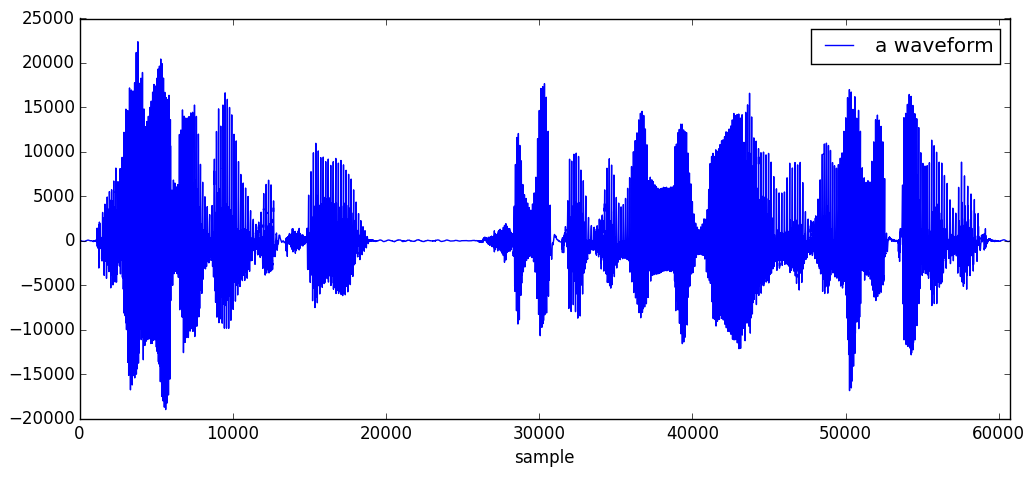

In [5]:
x, fs = wavread(joinpath(dirname(@__FILE__), "data", "test16k.wav"), format="native")
x = convert(Vector{Float64}, vec(x))
fs = convert(Int, fs)
wavplot(x)
inline_audioplayer(map(Int16, x), fs)

## Speech parameter extraction

To syntheisze a wavefrom, basically you need two speech parameters:

- excitation signal
- spectral parameters (e.g. Mel-cepstrum)

MelGenralizedCepstrums.jl supports extracting lots of spectral parameters.

### Excitation signal

In this notebook, we use a pre-extracted excitation signal, for test16k.wav in the example directory.

<source src="data:audio/wav;base64,UklGRqy0AwBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YXC0AwADAnKldH7AIkSkiqMCKUujozx0pFu4uaKSAC+kjMbBI+6FTaIRV0CkC0gJo91NqaNZt6mj3M20I9+PRaL83YUiVuDEIbAGsKNZT/Wjwvh0IgsLM6PR3/cjx6nPIy7YUiPeJrCj/lUJInmnaaOjEJmjkLAlo3RK1aM1/jokm45/vXaEBb27qKk9cMINPdnJozy7+p08TgcJvbB6073m5Aa+pbs0PZtG5D2WUCU8XxXEPLiQJb18XBq+W7IbPlfmfjxa8Yc9tpxqPiAaO74Vf4M8jX1JPAqI6rswzBG+co/oPd1JID4V0lq+oGG8PR3eOj2KGC09MhuuPUI6e77YFNy8liJtvZ7lhD2JIBe+J9yRPbqZjb3cbpG9YoTOPXdjeT20fQO+pBpwPQFhwz2kOow9VNiyPXn3Mj7v+kS74IYzPc5w2zyHUqS8C9E6vJ5v/b32Maq8/veSPeJwEr52lqe8jOMvPuaKG76XU9g9/lRMvkIuPb0USnq9ii5LvTsp+z0FupA6/QGuO2Wt/j1OcVk9gEN+Palbr735uv09paxHPQQGlj14HQY+6N4DPKQJC76KtO+8A7P2vA1NyL0oB5O9lcVdvn+xKb41aqw75R0MvhDlzj1xpCE8ER8ePcMJej6+rr88z5aoPX4tZr2U7E47xfb8PBmttDtJI2K9Sc/AvYzg372sQZU8r7O5vUrNZDwKdxq7DbREPQBIJT3YKuo9Anu4vXtIUj2OK8I9yJEFvqsinb1tdN49R3xHvDdPI7xciwO+QCxxPI4aDz6a1bE91RF7vcCy27x2qde8oHZCPYLfVD220ic9aj3ePX7GHb2k0je92InzvfC8e73mqUY9x/KbvJFZ2rwHaMY9gG9dPdT1Mr42EjY+pnqsPIoFab2HBts9aNDbPCfq3z2E7V4+IfaGuh9Fa70165i9SnAovgVqF7xCdkG95O/mvRybYz6Bet292ySnvYDnhT2OYDs9pXSOvRzOzr21ei09q1NRvVSET73bxFa9LZLoPWHXKL2geXi9YyrYPYzOOb5kxz29G1h6vTZk/L1iN9m7L8Cwu0u8Bj7vN0M+BDPAPcuIcLyDvhI+Ftn1vYiQc71YZxu638GIvXyLBz7lYqO9W27/PKMvTbw/irE9PjuRvQTfUr2qQh06yQxDvQMR7z1fuci8/hjgO+9b5D3LThY9pgcevqBcmbzVy0U99+S0PdKGAT3bp+U9xltTPr/MBL3ZFhg8XjD8vJpJBL48M3i9AUI+vRFYgL2dYyG8qqsWPdwJBb7FBvw8+WyjvYV2Wb1/5HS9+07xOziWeT3LnTI+PCT9PeuiSL1ZHCY+5o7dvXOiZb3S3pe9gIjUvVP76jyXcYa8+AYxvOyLaz1hMeu9OQE0vhnwIj5IH4a9l1GzvQljCD67/wU+HA05Pd2MML6G1Wk9RkLMvdyIM73pEda9lKnhvCaOSb2Y6v48XUr+vaHOgLzqJZC8MwgNvNB/HT7LFim+cVB2PdCygD1iZN49CrudPuA+jj0oyZc92RYUvsl2wLyZ9gQ+yO9NvTtcFD7U8f+9u2k7vuSfJ7xWqZk9hd9EvQBDUL0xcZA9GD+TPRTUwLu+nNU99NlTPVSwJb52tNm98qTLu3gtJL6Jtzm+efcBvYpqCr6+cms8WPiJvX/srj2RXto9rpuLPeHfYT3+xSM+ukbPvap46zu/Wjg++DHMPeKmiL1BHFA9bFYzvqu58j1QEZw80WTAvWjfJr0zGyQ+IQy7vO8g1DzT+VU7U+9EPW9jRL1cPGo+7+oxOrUeXDxtrrq9GgwEPouSPL4rH3I9s4bFvUB/xb2yMc68/tt5PQ7ulj2qGRY9DROuvUDyErrSvSk+aRSdvV69aDublMG9iSuBPbmiUzzC9Ra+IMJKPWddQb309cQ8XoUOPh6j1T18iSO+wt9lvcYOsL1Jqw+9uy8fvV/Nlz1Jp2a+7QQOvfRtBb16loi8NYYsPqAs0LxtEHQ9s5AevflaDD7m5Eu84JoHPQ1Beb0SjRM8UfYBPeJowD2qUte85MkwPbHLKT3kmZS8LzdfvoMR+j1pvje+iGSqPdrWYj3LUU29NtKbvBuw4z2xPFW+3ZizvdQLTD19cku9DnuNvK9oobwuYdc9hNsyPF0kQT2LxoY+JWrTPeHJ4DzOv5C8nYkBvo3dTT6LxLO94GO/unS8jTybbjK9FYhmvoZH0D11Lu48jkkbvr4//72Tt9G8SWmnPWjwGb3Vh149znj9u2snrzxO6q67psjPPeElFLpAtZ06quJXPYgW270+A8M9P89Gvg6ARb7tjfg8jt90PuZ5mTx/U4u9XZEGPs28ZjwLgDY6wa0UvgZ8fz4kzlS963bxPfne1zx7szE97VWDPZ77bL6+KKw9o1GBPQ9wMT5NhGE9gKjpPRGqBj6WBns8uWgtPvDr07tDa0m9mr2gPSXEHD1trAi9MKdQvpVxfr2S8fY9QhsMvp/FCj346Su+MfWuvfUg6r24h7m9WQl4PbpdLDw8vfO9oxAwPlSm77yeDSW+VyvsvQFG4jxWsw89uacDvJQGkzzrrGG9elHZPdKHWD0/f5690VwNvbrjWT7GmJ69NE6IPXl6nL29AeC81/kTPcI4iT2wwl49Ng+YPXcLcb3Pa4u9b21pPdXj8z3Wjo+8a8SGve2Q0rwwsQY9v0zqPTwRzTwyc3G9fe0vvZaiu7xHjAa+2zeUPKZllLw3wki+PHjdPR4/AD2JTyS9FMPKvLKpUjzfyRk9/b7uPQgQtL0skzO9XA8TvtJIpL2Y8yo+EUEbvm4ToTyIQJW9jn3uOqPR6r3JIK+9QPeIvfoEoj2DfBg9TYK4PZL9dDthJQC+PZRkvXk63L13drO9Oa4bPj8xd719hE8+V+TtPSm7MD73wAk9sxaEu8B/tjpZsus8TmjAvcwmvz0wbk2+kGaBPgiln70tZAo+JuXmvYDpuT084667jTezvOCLlj1zoQS8t+FTPS9sIb5gaxk+cbpJO5lCFb2w81G9JjXdPaFVMbv6dgu+OPn1vdFkR72VZV494Mk3vhJn+T1DBrs98QgEvRVMBj3kKr07lcOIu5HlNL0+RkE9pRQfvhaFV70+oc89EUKFvehTJr6SmyA9MAfnPfSzpz3bfam8N5eqvMKsAb6eMRG94ycbPc1IwT3/WxC9GSOyOwAdkD4n0Fy91tyCvaMnyLuhZB26UnxdPdBkF74hVoQ955mIvR7ORD1qV2A97GjVPaHbV73RMT49YQgVvHCp2L0MKBC+1SePPRRdLT7Q2zE9zYF5vYtkqjyMA8+96SkvvW0IJz5XkaW93h2QvUaON74grAQ+qouRPZMYCz4bs5W9gGauPa0c/LyuD+q9KRV2PXnAUL1voN484x6FvUK3bz2rVE29cvBWPeXmFrzMjIC9cVKLvt2Gej1yiBG+pa60PV4fqj2np5U9I3gRvp8u0zzRwy08VScLPlda0z37H7y9GUXOPb7XWj4apqm9F/4KvGDUaruLASy9zoDDvYfv8bzd3xY+fuZLPRdvkL2nyqc99wEEvVUXNzwH95O9Asn1vLY4Jb3RPwA9YwabOm9m6ryNZua9+/dNvlVncb6XERi92QrhOzEvnj0Kr909AGMHPItWkb3kI2Q9Ec2cvmO3Jj7M5Yo778T9vWHQEL0E7pE9lfm9PGxXwb1g+qG7j74tPluiaT0HkLU9d/Y1Ps2haD1k6GU+dQ4cPLsMEj4bsku+uR4XvBUSuT1r0pq9XZljvggJ7TvnF0c+O3PBPT7N+72IYFa7ZD+YvQVI6z0N/eE9gZ82vRwkwT068a88OkLIvTSeJL7HDwI9ar7jPUU7sL0ETQu+NwUKPcpwnb3KQqq9PmIdPpzSrT2Ld

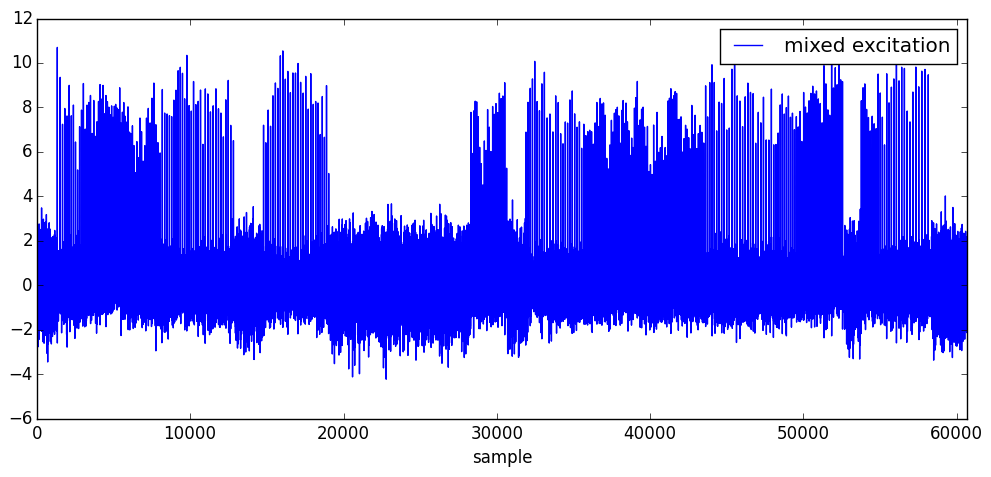

In [6]:
# Note about excitation
# fs: 16000
# frame period: 5.0 ms
# F0 analysis: esimated by WORLD.dio and WORLD.stonemask

# Excitation signal: perioic pulse for voiced segments and gaussian random values for un-voiced segments
# base_excitation = vec(readdlm(joinpath(dirname(@__FILE__), "data", "test16k_excitation.txt")))

# Mixed excitation generated using WORLD.jl
base_excitation = vec(readdlm(joinpath(dirname(@__FILE__), "data", "test16k_world_excitation.txt")))
wavplot(base_excitation, label="mixed excitation")
inline_audioplayer(base_excitation ./ maximum(base_excitation), fs)

## Split audio signal into overlapping time frames and apply windowing

This ia a basic step before mel-genrealized cesptrum analysiis. Note that windowing is essential for mel-generalized cepstrum analysis.

In [7]:
framelen = 512
hopsize = 80 # 5.0 ms for fs 16000
noverlap = framelen - hopsize

# Note that mgcep analysis basically assumes power-normalized window so that Σₙ w(n)² = 1
win = DSP.blackman(framelen) ./ sqrt(sumabs2(DSP.blackman(framelen)))
@assert isapprox(sumabs2(win), 1.0)

# create windowed signal matrix that each column represents a windowed time slice
as = arraysplit(x, framelen, noverlap)
xw = Array(Float64, framelen, length(as))
for t=1:length(as)
    xw[:,t] = as[t]
end

# col-wise windowing
xw .*= win;
@show size(xw)

size(xw) = (512,753)

(512,753)

## Spectral parameter estimation

You can extact lots of spectral parameters using MelGenrealizedCepstrums.jl. In the follwoing example, we extract mel-cepstrum from the windowed signal and then show the spectral envelope estimte.

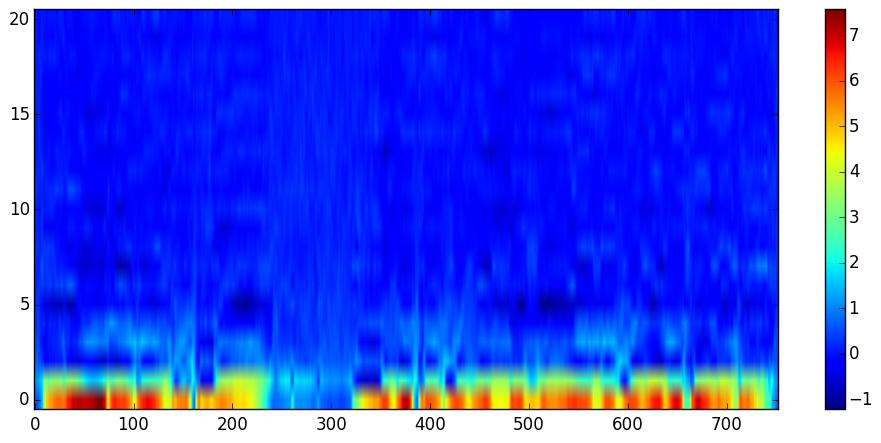

PyObject <matplotlib.colorbar.Colorbar instance at 0x7faed4d98b90>

In [8]:
c = estimate(MelCepstrum(20, mcepalpha(fs)), xw)
imshow(c, origin="lower", aspect="auto")
colorbar()

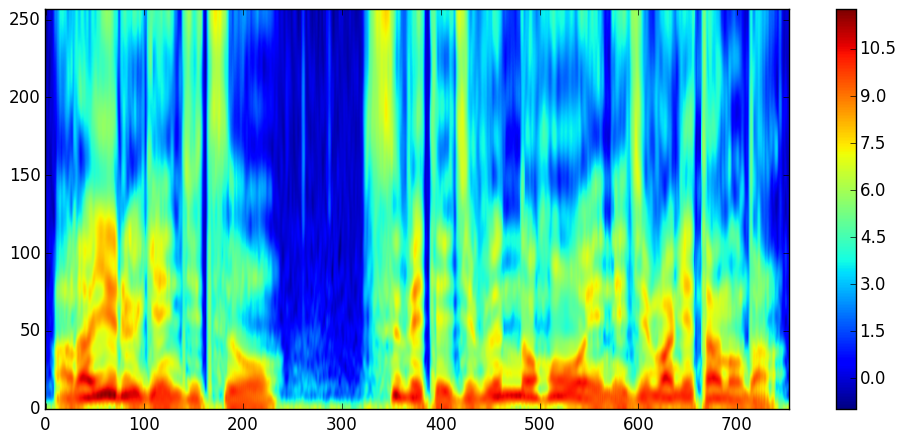

PyObject <matplotlib.colorbar.Colorbar instance at 0x7faed4b8f248>

In [9]:
# Let's see spectral envelope estimate
imshow(real(mgc2sp(c, framelen)), origin="lower", aspect="auto")
colorbar()

## Compare synthesis filters

Let's compare syntheiszed waveform with various synthesis filters.

### Synthesis from Cepstrum

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7//////////v/8//7//v///wIA//8AAAAA///+/wAAAgD//wEAAQACAAQAAAACAAEAAQAAAAEAAAAAAAEAAQD//wAAAQACAAMABQAFAAYABgAHAAcABgAGAAgABgAGAAkABwAJAAcABwAHAAYACAAIAAgACgAKAAsACQAMAA0ADQAPAA8ADgAOAA4ADgANAAoACQAJAAYABwAHAAcACgAJAAkACAAIAAkACAAHAAUAAwADAAAAAAD///7//v/+//z//P/9//v/+v/7//r/+v/4//j/+v/5//f/9//3//f/9//3//n/+P/4//f/9v/3//f/9//5//n/9v/6//r/+f/8//z//v8CAAEAAgACAAEAAwADAAEABgAEAAMABQAFAAUABQAGAAYABQAEAAcABgAEAAcABAAEAAMAAAAAAP////8CAAEAAAACAAAA/v////7////9//3//f/9//z//P/7//r//P/6//r//P/7//r/+v/7//3//f/+/wIAAAABAAEAAQABAAEAAAABAAIA//8BAAAA////////AAADAAMAAgAFAAQABAAEAAMABAADAAIAAwABAP7/AQAAAP7/AAABAAAA/f/+//3//f/7//v/+v/5//f/9v/1//T/9f/y//L/8v/y//X/9f/1//T/9P/2//X/9//1//T/9f/2//X/9P/2//f/9//5//n/+P/4//n/+P/1//b/9f/1//T/9P/1//X/9f/3//T/9f/3//j/9//4//b/+f/5//f/9//6//n/+v/6//v/+///////AAD//wMAAQADAAIAAgACAAUABgAGAAUABgAJAAgACQAHAAoACgAJAAkACgAJAAwADQALAAoACQAJAAgACQAEAAUABAADAAQAAgACAAEAAgABAAAA/v//////AAD+/////v////v//f/6//v//P/7//r//P/4//j/+P/3//b/9f/3//b/9//5//z/+//8//r//v/9//3//v////z///////7//f/9/////v/+//7//////wEA//8BAAEAAAABAP//+v/7///////9//7///////3/AAAAAAIAAwAEAAUAAgADAAYACQAKAAwADwASABUAFwAXABsAHAAeABwAHAAfAB4AIAAeAB0AGwAaABsAGgAYABoAGQAWABIAEQAQAA8ADQAKAAoACQAIAAUABwAEAAUAAgABAAAAAQABAAIAAAD/////AQACAAAAAAAAAAIAAgACAAEAAgAAAAAA///8//7//v/9//3//f/+/wAA///+//v/+v/8//j/+P/2//X/9P/y/+//8f/x//P/8v/w/+//7f/r/+3/6v/t/+//8v/0//T/9v/3//b/+P/0//j/9v/4//f/+f/7//z///8AAAIAAAADAAMAAwACAAUABQAEAAEAAQABAP//AAABAAIAAwAEAAQABQAFAAMAAQACAAAA/P/7//z//v/+//7//P/8//z//f/9//z/AQAAAAAAAAD//wAA/v/+//v/+//8//7//f///wAA///9//7/AQACAAIAAQD/////AwABAAAA/P/9//7/AgABAAMAAwACAAUABAAEAAEAAgD//wAAAAD///j/+f/1//f/+f/7//j/+f/6////BAADAAUACAAIAAcABQAAAPz/+f/6//r/+f/7//v//f8AAAEAAQADAAQAAwAAAPn/8f/t/+v/7P/v//H/8P/0/+//9P/0//T/8P/u/+v/5v/k/+X/5v/r//P/9f/+/wAABgAAAP///P/4/+7/5//m/+j/6f/s/+3/9P///wcAEAATABMADgANAAsACAABAPz/8//w//P/9/8CAAkAEQAVABkAHQAbAB0AFQAQAAoACgALABAAFAAUABkAFQATAA0ADAAEAAAAAAAAAAAAAQAEAAcACwALAAwABAAFAP7/AgACAAcACgAPAAwAEQASABYAGQAXABIAEQAKAAIA/v/5//f/7f/z/+v/+P/z/wUABAAPABEAHAAcACcAIwAoABsAEQAAAPT/6v/k/+D/3v/k/+z/+v8GABcAGwAmABoAFQACAPj/5//d/8r/wv+7/8T/1P/t/wUAIwA3AEkAUwBTAEkANQAaAPb/2v/F/73/uP+y/6//uf/Q/+r/EQA2AFkAdQB6AHYAUQApAO//uf+H/2n/Xf9n/4f/0/8YAFYAYwBVACkAAQDb/8n/w/+8/8b/yP/p/w4APwBJADoA8f+e/zz/Df/3/hr/Ov95/6v/6/8sAGIAgQB3AGYATABaAHUAswDYAPwA+QDrAKwAXgDx/53/WP8z/xz/Ef8n/1H/rf8UAI8A2AD4ANsAnwBSAB0AEAA9AIgA4QAkATIBJwHhAI4ADgCH/+7+Zf4P/g/+Z/4R/+r/vQBdAccB7QHUAZ8BRwHZAGIA6f9l/+b+gv5S/kn+Yv57/oP+lv6y/uX+Qf+c/93/6P/p/wgAXQC8ABQBQgFYAWsBlQHiASICVAJZAj8C+AGVARYBmQD7/1v/tv4r/pn9Of0z/Yr9Lf4I//H/6AD5AeECWQMxA4kChAElAJL+7PyG+3b67fm5+d/5N/rm+u/7Iv0z/uj+dv/7/4gA9QBqAb4B7AHnAcYBcwHxADEAd/8D/zD/6v/fAM8BjwJWA84D7wN4A5sCigGzAAMAnP9u/8P/tAD2AVEDWAT2BPUEhgSaA2oC3gAy/7f95fzM/Br9if3n/Vf++/76/yMBPgKxAogCvQENAXwAEQB5/3r+Xf19/Fr8xvyN/Xf+hv+DAFUB5QFVAogCeQIOAp8BBgGeAD0A7P93/xP/3/6W/lz+D/7u/dD9q/1N/QD9Ev3v/Qn/IwDhAH0BwgEJAk8CaQIeAj0BMQDa/hz+o/3K/d/9P/5p/sD+aP9kAEcBdAH6AO3/zv67/Rz9xPzo/Cn9xf0r/qH+1/76/pj+FP5i/ez8Q/zE+0b7lftL/NT9S/+9ALUBiwJ2A38EgwUsBkQGxAXqBNoD2wLgAccAcP/0/QX9tPwb/Rf+H//3/2wA2gBVAbMB4AHDAWYBBwEOAWsBKgKqAgYDAQMXAw8D0wJDAigB5/+D/mH9aPzP+5779vvX/Az+Ev+y//b/CQARAMr/I//f/U78C/u2+oz70vxL/n//wADdAdoCNAPeAhcCGAE6ADv/bf6H/Sj91vz1/EL9t/0U/lb+CP9FALABOwNYBFIF8QVhBo8G6QWsBBcDiwEbANf+5P1f/ef8AP1o/WX+Jf+s/xIAkQAZAV4BSAE3AWQBtwGnATsBvAAjALL/OP9y/5//IACJAEMBdwGnAV0BQQFIAID/of5B/v39If6N/iX/zP+OAPwAWQE4AXQBIQH9AIIA5v8H/1f+Yv7P/iz/S/8//x7/J/+B/w4AYQD+/3b//P5E/xkAngP0CCIPKRRyF6MZnRo5G2sa+xcAEy8NTwdEA8UAZQCgAEIBFAKgA9cF7QfOCd0KKQuwCuYJBglKCFYHlAZlBXAESAPBAjICDQKyAb0BkgHAAbUBDgIQAlcCPwJSAhcC8AGvAYQBWQEqAfkAvwCaAHsAgQB9AH0AYQBGAE4AUgBxAFsAUwBAAEQATwA1AEsAFwA4APv/JgD7/yoA9v8iAPn/MQABAB0A//8ZAB4ABAD8/+P/EQD6/xkA7f8NANb/HADz/ysA6P8cAO//IADw/yQA+f8PAPX/BgAGAAQAGgD0/w8A3v8nAAcAJQDg//X/2/8KAAUAIgAGAPn/7/8BABMAIgAhAPr/6//l/w0AGwANABAA8v/0/+r/AAAHAAEA///1/+b/9f/+/ygABgAQAPz/DAAKA

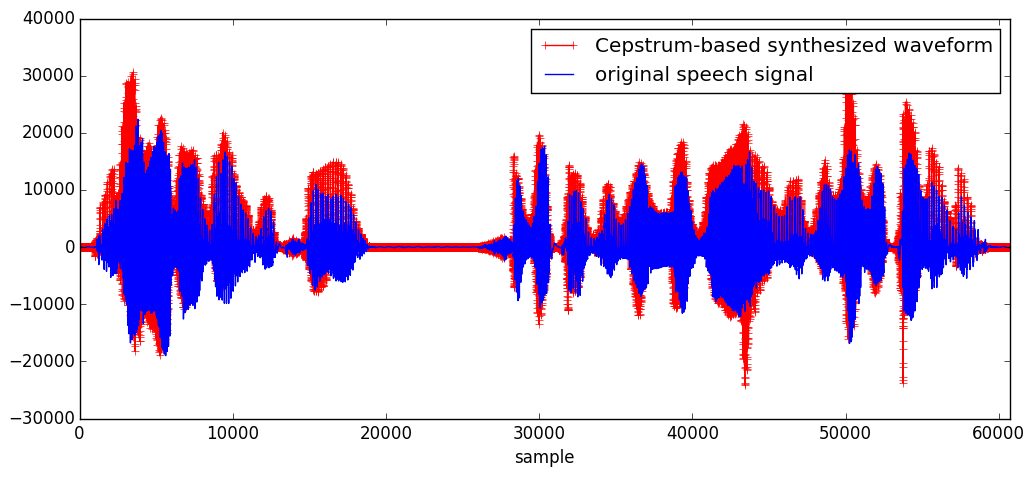

In [10]:
c = estimate(LinearCepstrum(25), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Cepstrum-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from Mel-Cepstrum

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7/AAD////////9//////8AAAMA//8BAAEAAAD//wEAAwD//wEAAQACAAQAAAABAAEAAAD+/wAA///+/wAAAAD+////AAABAAIAAwADAAQABAAEAAQAAwADAAUAAwADAAYAAwAFAAIAAgACAAEAAwADAAMABQAFAAYABQAHAAgACAAKAAoACAAJAAkACAAHAAUABAAEAAIAAwADAAMABwAGAAcABgAGAAgACAAHAAYABQAFAAQABAAEAAUABQAGAAQABAAGAAMAAwAEAAMAAwABAAIABAAFAAMABAADAAQABAAEAAYABQAFAAMAAgACAAIAAQACAAIA//8CAAIAAQADAAMABQAIAAYABgAGAAQABQAEAAIABgAEAAIABAAEAAMAAgADAAIAAQAAAAIAAgAAAAMAAAAAAP///v/+//3///8BAAEAAAACAAAAAAAAAP//AQD///////8AAP////8AAP//AQAAAP//AQABAP7///8AAAEAAQACAAQAAwADAAMAAgACAAEAAQABAAEA//8AAP7//v/9//3//v8AAAAA//8CAAAAAAAAAP//AQAAAAAAAQD///3/AAD+//3///8AAAAA/f/+//3//f/7//z/+//8//n/+f/5//n/+v/3//j/+f/6//3//P/9//v/+//9//z//v/8//r/+//8//r/+f/7//z/+//8//z/+f/5//n/9//1//X/8//z//L/8//z//P/8//1//P/8//2//f/9f/2//T/9//2//X/9P/4//b/9v/2//f/9v/6//n/+v/5//v/+P/6//j/9//3//j/+P/5//f/+P/7//n/+f/4//r/+v/4//n/+P/5//v//P/5//r/+f/5//n/+v/3//j/+P/4//r/+f/6//n/+//6//r/+f/7//v//f/7//3//f/+//v//v/6//z//f/9//z//v/6//r/+v/5//j/+P/5//n/+f/8//3//f/9//z////+//7///////z////+//3/+//8//3//P/8//z//P/8//3//P/8//z/+//9//n/9//4//z//P/7//3//v////3/AAD//wEAAQACAAIA//8AAAIABAAEAAYACAAJAAwACwALAAwADQANAAoACgAMAAoACwAIAAcABgAGAAcACAAFAAkACAAGAAUABQAGAAcABwAGAAgACQAJAAkADAALAA0ADAAMAA0ADgAPABAADgAOAA4AEAAQAA4ADQANAA4ADgANAAwADAAKAAoACQAGAAgACAAIAAcABwAIAAsACQAJAAYABAAHAAQABAACAAIAAQD///7/AAAAAAIAAQD///7//P/6//z/+v/9//7/AQACAAMAAwADAAEAAgD9/wEA/v8AAP3//////wAAAgACAAMAAQACAAEAAAD+///////+//z/+v/7//j/+//7//v//f/9//7//v////z/+//8//v/+P/4//n/+//8//z/+v/6//v//f/8//v////+//7//v/+/////f/+//v/+//8//3//P/+//7//P/6//v//v////7//v/7//v////+//3/+f/7//z/AAD+/wAA///+/wAA//////3//f/8//3//f/7//b/9//0//f/+f/6//j/+f/6//7/AgABAAMABwAGAAYABAAAAPz/+v/7//v/+v/8//v//f/+//7//f/+//7//v/8//b/7//s/+z/7//0//b/9v/6//T/+f/3//T/8P/u/+r/5v/l/+f/6v/w//j//P8DAAUACwADAAAA+//1/+r/5P/k/+f/6f/t/+3/9P/+/wUACwALAAgAAgD///3/+v/1//L/7v/t//P/+P8CAAcADAALAAoACwAFAAYA/v/6//b/+v8AAAkAEAATABgAEwARAAkABQD8//b/9P/z//P/9f/8/wEACAAKAAsABAAGAP//AgACAAUABwAMAAwAEQAUABgAGgAXABAADgAFAP7/+v/3//b/7//1//H//v/7/wwACQASABQAHAAcACgAIwApAB0AFAABAPn/7P/q/+D/4v/i/+z/9P8DAA0AFgAbABUADgABAPj/7P/k/9X/zv/K/9P/4v/5/wwAJAAvADwAPgA+ADEAIgAIAO//1//O/8r/zf/G/8X/yf/e/+7/EQAtAE0AYABlAGAAQgAjAPX/yv+k/47/hP+M/6f/5P8aAEYAQwAtAPz/3P+6/7b/tv+9/8//4f8KADsAagB0AFYAAACb/zD/9P7Z/vX+Ff9d/5n/8P8+AIMAngCRAGsASABBAFwAkAC9AOAA7QDjALgAcAAPALj/av8w/wT/6v79/jb/pf8oALgAFAE7ASQB4QCPAEsANwBZAKAA9QA2AUIBLwHZAG4A1f82/43+Af61/cf9Nf72/uf/0QCFAQUCMwIfAtgBaQHYAE0Axv9Q/+j+qf6S/pj+pv6i/nv+XP5E/k7+i/7d/i7/Z/+v/yIAxABZAckB8AHnAcoBvQHQAdkB1wGxAXgBIwHCAFQA8v95/wD/iP4x/tv9vf3x/Xr+O/8lAAsB+gHtArAD7gOSA7QCjwEXAIX+6PyX+5D6EPrP+eP5GPql+oP7ifxn/fL9Y/7m/oH/DgCsAD0BqwHrAf8B1gFkAaEAz/80/yv/pP9YAAwBogFFAqwC1AKHAvEBRAHlAL0A4gA/ARUCdgMKBY0GlAcDCK4HwwY/BWYDQAEW/1P9XvxH/KT8LP2h/Rj+rP6C/3MATAGCAScBSgCm/zz/Bf+m/t/97vwo/AT8UPzV/GX9Cv6s/jT/o/8FAEIAPADh/4r/Hv8E/wr/Ov9O/37/1f8XAFEAXABgADsA5P9A/5j+W/7n/r7/mQApAaYB2QEhAm0ClAJVAo4BpQB7/+D+e/6Z/pD+t/6d/qr+Ev/P/3AAZQDN/9f+9/1d/T/9df37/Yj+NP+T/93/1/+r//b+Jf4v/Yz8xvtE+8H6HPvL+139xP4/ACgB/QHFAq8DdQT7BPYEnwT+A18DvgI1AlgBPADO/vv9pf0N/u3+3v+SAP0AdQEdArQCIgM3AwEDrwK7AgIDqAP5AxMEtQNrA/ECPgI4Abv/Jf6K/F37kfpS+qn6kvsA/ZH+1v+IANIA1QC+AEkAdP8N/mz8Lvvf+qT7tfzg/bT+m/9bAAABCgF+AKn/yf5B/sb9nv1x/cj9Ev6V/hP/h//C/7v/DgDUALUBvgJ/A2UEJAXtBXIGJwYqBc8DZQILAcT/wP4i/qD9oP34/eD+lP8KAGgA9gCNAeMB7AEUAn8CAgMJA6EC8wETATIAPP/Z/l/+SP4//rD+y/4a/yL/ef8I/9v+lv7P/vL+YP/b/4EA/gCEAYMBjAHpAK8Aw/9F/1r+of3H/Hz86PzV/Z/+K/9W/3L/hv/y/1QAogAdAKT/NP+l/30A9QMCCbYO+hKUFTUXzhcPGAkXhhS6D00KIQXaATQAUADkAKkBggLcA9AFoQf3CF0J/wgvCD4HqAZ1BkQG6wXWBGUDSwFq/179sPu/+U747vZh9i72CvcT+Ln5+Ppm/E79Qv7D/in/Bf+L/o/9bfwo+wf6+Pgm+GH34PaP9uL2cPd8+HL5o/q9++n88/26/n7/yP8wAAsAJwDV/8n/XP9K//D+/f68/t/+6P5M/6v/EgCHAAkBtgExArUC9AJBAzQDZwMwAyQDqwKMAhwCAQKTAZoBTQFaATYBWQFlAYwBrwGvAdEBwQH7AeEB2gGFAWEBKgEUAeEAtgBwAC4A///x/+j/6f/S/7D/mP+h/8L/3f/G/8//pP+o/5D/n/+R/37/aP9P/zP/Of87/2L/QP9Q/z7/W/9f/

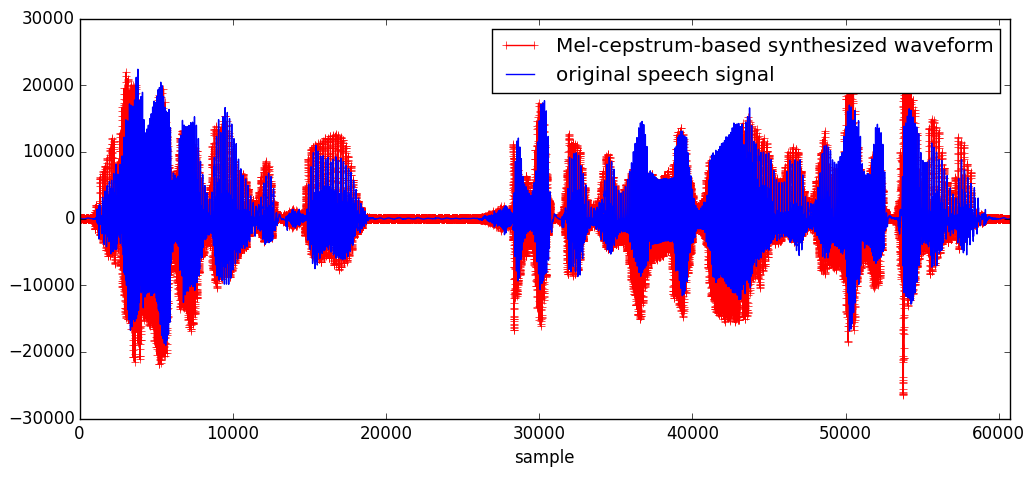

In [11]:
c = estimate(MelCepstrum(25, mcepalpha(fs)), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Mel-cepstrum-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from Mel-generalized cepstrum

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7/AAD////////9//////8AAAMA//8BAAEAAAD//wEAAwD//wEAAQACAAQAAAABAAEAAAD+/wAA///+/wAAAAD+////AAABAAIAAwADAAQABAAEAAQAAwADAAUAAgADAAUAAwAFAAIAAgACAAEAAwADAAMABQAFAAYABAAGAAcACAAKAAkACAAIAAgABwAHAAQAAwAEAAEAAwADAAMABgAFAAYABgAGAAcABwAGAAUABAAEAAMAAwADAAQABAAFAAMABAAFAAMAAgAEAAMAAwABAAEABAAEAAMAAwADAAMABAAEAAYABQAEAAMAAQACAAEAAQACAAIA//8CAAIAAQADAAMABgAIAAcABgAGAAQABQAEAAIABgAEAAMABAAFAAQAAwAEAAMAAgABAAMAAgABAAMAAQABAAAA/v////7/AAACAAIAAQADAAEAAAABAAAAAgAAAAAAAAABAAAAAAABAAAAAgAAAAAAAQABAP////8AAAEAAQACAAUAAwADAAMAAgACAAIAAQACAAIA//8AAP///v/+//7///8BAAEAAAADAAEAAQABAAAAAgABAAEAAQD///3/AAD///7/AAABAAEA/f////3//f/8//z//P/8//r/+v/5//n/+//4//n/+f/6//3//P/9//v/+//9//z//v/8//r/+//8//r/+f/7//z/+//8//z/+f/5//n/9//1//X/8//z//L/8//z//T/8//1//P/8//2//f/9f/2//T/9//2//X/9f/4//b/9v/2//f/9v/6//n/+f/4//r/9//5//f/9v/1//f/9//4//b/9//6//j/+P/3//n/+f/3//j/9//4//r/+//5//n/+P/5//n/+v/2//f/9//3//n/+P/4//j/+v/5//n/+P/5//n/+//6//v/+//8//n/+//4//r/+v/6//n//P/3//j/+P/3//b/9v/3//f/9//6//v/+//7//n//f/8//z//f/9//r//P/8//v/+f/6//v/+v/6//r/+v/6//v/+v/6//r/+f/7//f/9f/2//r/+v/5//v//P/8//r//v/9//////8AAAAA/f/+/wAAAgADAAQABgAIAAoACgAJAAsACwALAAkACAALAAkACgAHAAYABgAFAAcABwAFAAkACAAGAAUABQAGAAcABwAGAAgACgAJAAkADQAMAA4ADQANAA0ADgAPABAADgANAA4AEAAQAA4ADQANAA4ADgANAAwADAAKAAoACQAGAAgACAAIAAgACAAJAAwACwAKAAcABgAJAAYABgAEAAQAAgABAAAAAQACAAQAAwABAP///f/7//3/+//+////AgADAAQABAAEAAIAAwD+/wIA//8BAP//AAAAAAEAAwAEAAUAAwAEAAMAAgAAAAEAAQAAAP7//f/9//r//f/9//3//////wAAAAABAP7//f/+//z/+f/6//v//f/+//7//P/8//3//v/9//z/AAD////////+/wAA/v/+//z//P/9//7//f///////f/7//z///8AAP///v/8//z/AAD+//7/+v/8//3/AAD//wEAAAD//wEA//8AAP3//v/8//7//f/8//b/+P/1//j/+f/7//j/+f/6//7/AgABAAMABgAGAAYABAAAAPz/+v/7//v/+v/8//v//f/+/////f/+///////8//b/7v/s/+v/7//z//b/9v/5//P/+f/3//T/8P/t/+r/5//l/+f/6v/w//j/+/8DAAUACgADAAAA+v/0/+n/5P/j/+b/6P/s/+z/8//9/wQACgALAAgAAQD+//z/+f/0//L/7f/s//P/+f8DAAgADQALAAsACwAFAAYA/v/6//b/+f///wkAEAATABgAEwARAAkABgD8//b/9P/y//P/9f/8/wIACQALAA0ABgAIAAEABAADAAYACAAMAAwAEQAUABgAGgAXABAADgAFAP7/+f/3//X/7v/2//L/AAD9/w8ADAAVABYAHwAfACsAJgAsAB8AFgAEAPz/7//t/+P/5P/j/+3/9P8DAA4AFwAdABcAEQAFAPz/8P/n/9j/0P/L/9P/4//5/wwAJAAvADwAPwA/ADIAIwAJAPD/2P/O/8r/zf/G/8T/yf/e/+//EgAuAE4AYgBnAGMARQAnAPv/0f+r/5T/if+P/6f/4/8XAEEAPQAoAPn/3f++/7v/vP/B/9H/4P8HADcAZQBvAFIA/f+a/zD/9f7a/vP+EP9V/47/5v82AH8AnwCWAHIATgBGAF0AjgC3ANcA4gDYALIAcQAYAMb/ev87/wn/5/70/ij/lv8aAKwADgE8AS8B9ACnAGMASgBkAKIA8AAtATgBKAHYAHIA3/9C/5r+Cv63/b/9JP7d/sz/uAB1AQACOQIvAuwBfgHrAFsAz/9T/+b+pP6M/pL+ov6i/n7+YP5F/kj+ff7H/hP/Tf+b/xgAxwBmAeEBDgIHAucB0wHcAdwB0gGmAWoBFgG4AE0A7v90//j+ev4b/sH9o/3b/Wv+M/8mABYBDQIJA84DCQSkA70CjgENAHb+2PyI+4P6BvrJ+eL5Hfqw+pL7m/x7/Qn+f/4J/63/QQDlAHUB4gEdAikC9wF4AagAyP8h/wv/d/8fAMsAXAH9AWICiAI8Aq0BBwGwAJEAwAAoAQsCeAMWBZ4GpAcNCK0HsQYZBSkD7QC0/uv8/Pvz+2f8DP2k/UD+9/7n/+0A0wETAr0B5QBFANz/pP8+/2n+Y/2A/Dj8YPzF/Dv90P1s/vr+eP/v/z0AQADh/3n/8/69/qv+zf7e/hX/gP/f/zoAYgB4AFAA3/8O/y/+tv0N/r3+hf8XAK0ADAGNARkCgAJ7AuIBHAEIAHf/FP8t/xn/L/8B//v+T//6/44AeADZ/+T+EP6G/Xv9wv1R/t7+gv/U/w8A/f/I/w//Pf5N/bj8BPyX+yX7h/st/Kj98P5KABcB2QGWAnsDQgTTBOQEpwQhBJQD9wJhAmwBNQCw/sr9Z/3G/aH+kv9OAMcAUAEHAqcCFQMiA94CfwKCAswCfgPkAxgE1gOhAzcDjwKMAQkAY/6w/Gf7f/ow+oP6cPvl/H3+x/+DANsA7QDjAHUAnv8x/o38UfsH+8772fz0/bf+jf9BAN4A4ABMAHH/k/4R/qD9g/1g/bz9CP6N/g3/g//D/8P/HQDjAL0BuAJsA0YEAAXEBT4G3wXRBHIDFQLUAKr/xP5B/tX96P1P/jv/5f9EAIUA8ABmAaMBngHCATkC2AIDA7sCKgJnAZwAsf9J/8L+mf55/tn+6/41/zf/gv8C/8r+f/6v/sf+Lv+w/2MA9gCXAbYB1QFCAQsBFQB4/2r+kP2d/Dv8nvyK/Vv+8P4t/1//h//+/2cAsQAoAK3/PP+q/38A7wPvCJMOzRJfFfwWlRfkF/QWiBTQD3kKYgUqAooAswBUASECAgN2BJEGgAjpCVYK8QkICfwHUAcPB9YGfwZqBfAD2gEdAFX+9fxA++H5Zfih9z33+Pfo+GP6YvuI/ET9QP4B/8D/9f+z/9X+u/11/En7HvoS+fj3G/eE9rj2V/eS+MH5Ivtd/KD9vf6R/1kAkADQAHIAVgDY/7P/Of8a/63+nv5B/k/+UP62/h3/iv8KAJkAYAH8AaQC+gJRAz0DXgMQA+oCVQIXAoYBSgHFAL4AcgCIAHkAswDbAB4BZAGEAcUByQEQAvUB5gGBAUoB/ADOAIQARQDy/6r/gP98/4T/mf+b/5P/lf+2/+3/FwALABsA8P/u/8v/zP+t/4n/Zf8//xj/GP8b/0f/Mf9N/0n/df+G/

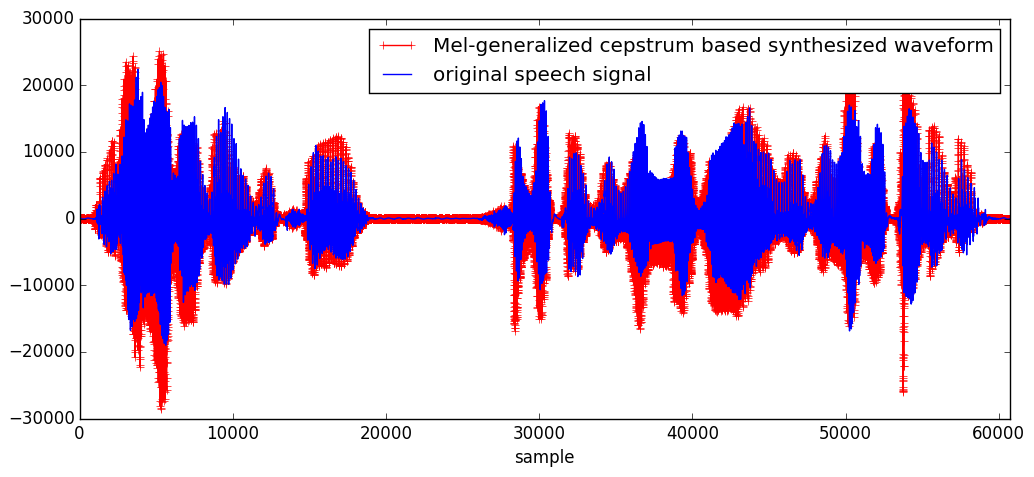

In [12]:
c = estimate(MelGeneralizedCepstrum(25, mcepalpha(fs), -1/4), xw)
y = synthesis(base_excitation, c, hopsize)
wavcompare(x, y, label="Mel-generalized cepstrum based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from LPC

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7/AAD////////9//////8AAAMA//8BAAEAAAD+/wEAAwD//wEAAQACAAQA//8BAAEAAAD//wAA///+/wAAAAD+////AAABAAIAAwADAAUABAAFAAUAAwAEAAUAAwADAAYAAwAGAAMAAwADAAEABAAEAAMABQAGAAYABAAHAAgACQALAAoACQAJAAkACQAIAAUABAAEAAIABAADAAQABwAGAAcABgAGAAcABwAGAAUABAAEAAIAAwADAAMABAAEAAIAAwAFAAIAAgAEAAMAAwAAAAEAAwADAAIAAgACAAIAAwADAAQABAADAAIAAQACAAIAAQADAAMAAAADAAMAAgAEAAQABgAIAAcABwAHAAUABgAGAAQACAAFAAQABgAGAAUABAAFAAUABAACAAUABAADAAUAAgABAAEA//////7/AAACAAIAAQADAAEAAAABAAAAAgAAAAAAAAABAAAA//8AAP//AAD/////AQABAP7///8AAAEAAQACAAUABAAEAAQAAwACAAIAAQABAAIAAAABAAAA///+//////8BAAIAAQADAAIAAQABAAAAAQAAAAAAAQD///z////+//z//v///////P/9//z//P/6//v/+v/6//f/9//3//f/+P/1//b/9v/3//r/+v/6//n/+f/7//n//P/6//j/+f/5//j/9//5//r/+f/7//r/+P/4//j/9//0//X/8v/z//L/8v/z//P/8//1//L/8//1//b/9P/1//P/9f/1//P/8//2//X/9f/1//b/9f/5//j/+f/3//r/+P/5//j/+P/3//n/+v/6//n/+f/8//r/+//5//z/+//6//r/+v/7//3//v/7//v/+v/7//r/+//3//n/+P/4//n/+P/5//n/+v/5//r/+P/6//r//P/6//v//P/8//j/+//4//r/+//6//r//P/4//j/+P/3//f/9v/4//j/+P/7//3//P/9//v//v/9//3//v/+//v//f/+//z/+v/6//z/+//7//v//P/7//7//P/9//3//P/+//v/+P/5//z//P/7//z//f/9//v//v/+/wAAAQABAAIA//8AAAMABQAFAAcACgAMAA4ADgAOABEAEgASABAAEAASABAAEgAQAA8ADgANAA4ADgAMABAADwANAAsACwAMAAwACwAKAAwADAAMAAoADgANAA4ADAAMAAsADQANAA8ADgAMAA4AEAAQAA4ADgAOABEAEAAQAA8ADwANAA0ADAAJAAsACwAKAAoACgALAA0ACwALAAgABgAIAAUABQADAAMAAQD///3//////wEAAAD+//3/+//5//v/+f/8//7/AAACAAIAAwAEAAIAAwD+/wEA//8BAP//AQACAAIABQAEAAYAAwAFAAUABAADAAUABAAEAAEAAAAAAP7///8AAAAAAQACAAIAAwADAAEA//8AAP7/+v/6//v//f/+//7//P/8//z//v/9//3/AQAAAAAAAAAAAAEA//////3//f/9/////v8AAAEAAAD+//7/AQACAAEAAQD///7/AgAAAAAA+//9//3/AQAAAAIAAgABAAQAAgACAP//AAD+///////+//f/+P/0//b/+P/4//b/9//5//3/AQAAAAMABwAHAAcABQACAP7//P/9//3/+//9//3///8BAAIAAQACAAEAAQD+//f/7v/q/+j/6f/s/+3/7f/w/+z/8f/x/+//6//p/+f/5P/i/+T/5//t//b/+f8CAAQACwAGAAYAAgD9//P/7f/s/+//8P/z//L/+P8BAAcADQANAAsABgAEAAIA///6//f/8f/u//P/9/8AAAUACgALAA0ADwAMAA4ABwADAAAAAgAGAA0AEQASABYAEAANAAUAAgD6//X/9f/1//b/+P/9/wEABgAGAAcA/v/+//f/+//7/wAAAwAKAAoAEQAVABoAHgAbABUAEwALAAMA/v/6//j/7//2/+///f/4/wgABQAMAAwAFQAVACEAHgAlABsAFAAGAP3/9f/v/+n/5v/p/+7/+P8CABAAFAAcABMADwABAPr/7v/n/9f/z//K/9H/3//0/wcAHgAtADkAQQBBADgAKQATAPn/5P/Z/9b/1v/N/8b/yP/X/+X/AgAdADoATgBVAFUAOwAgAPf/0P+u/5v/lP+b/7P/7f8cAD8AMwAWAOX/xv+v/7T/wv/R/+v//P8iAEYAaQBgADkA3v+B/x//9P7m/g3/MP9z/6n/8v83AG4AhgBzAFYANwBDAGcArADbAAUBBgH9AMcAgQAcAMn/e/9C/xX/9f79/iL/ff/o/2sAwgD3APEAywCKAFcAQABhAJ4A8AAvAT4BMwHnAIoA/v9u/8/+Sf72/fv9T/73/sr/nwBFAcAB+AHyAcYBbwH6AH0AAQCA/w//t/6R/of+lv6Y/oP+cv5m/mz+of7g/h//Sf+I//7/rQBbAegBLwI7AikCFQIbAhAC/wHPAZoBVQEPAb4AdwALAIz/9/5s/tT9ZP1I/X/9AP67/pb/kQC1AbMCPQMhA4QCigE7AL/+NP3m++P6WvoY+if6XPrg+rr7vfyd/S/+sf5N/wkAuQB8ASYCrAL1AgwD0gJCAkwBPgBj/yT/fP8qAPgAuAGTAi0DfgNDA6kCzgEZAXAA9/+f/7z/dwCMAcYCuwNaBGcEBwQgA+4BVwCs/kH9lfyr/Cv9yP1J/sD+Sv8UAPcAzgEGArUB2wA/AOP/0f+t/y3/fP7g/cf9Bv5u/s7+Rv+5/zUArgBPAeQBUwJiAl8CFQLhAZEBKAFqAJL/3v4r/rP9Vv1H/UT9Ov3v/LX82vzR/Qf/PAAEAZ0B3AEiAnECmQJiAo8BkQBC/4j+BP4X/g/+TP5O/oz+Kv8rABIBPwG8AKf/lv6o/UH9Hv1r/bH9O/58/sz+zf64/hj+W/2D/A/8mftp+0P70/uz/E3+2f9iAXACPAP8A7AEUQWnBZ8FOgWmBPcDVgOtAssBlgAX/wH+W/1O/b/9Rf60/vn+bP8xAAIBvQEkAjkCIgJJApkCKgNbA1AD2wKNAjoC1wFEATwAD/+6/aj8y/ti+3L7DPwe/Wn+cv8MAE0AXQBVAO3/IP/G/Tv8GPvq+tD7BP1M/kH/RgArAe4BEAKPAbsA3P9W/+D+t/57/qv+s/7o/gv/Jv8M/8T+4f6D/1sAfwGEAsED7QQSBvEG4QYXBswEVwPKATAAu/6l/a/8aPya/Ij9WP4B/5X/SAD4AFkBWQFlAbYBLgJEAv4BoAEbAaAA+P/Z/4L/af8+/4P/ZP9t/zD/YP/r/tH+sv4L/1H/wf8zAJwA4QAkAQwB/ACFAIYAEADp/3j//P5H/s/9C/6i/hz/U/9d/1X/Yf+2/ywAbAD2/3n/Gf+C/2QA5AMSCfQOihNdFhsYuxgRGSAYwBUpEQ0MHgcMBFwCVgJ0ArMCBgP0A3oF0wbqBzUI7wdJB9IGugYUB0gHZgebBn0FxANaAqAAA//z/DT7kPkA+S/5h/r9+9H9Jv94AFsBMgKOAnACuQGXAE//Lv50/Qb9xPx2/Cf84fvF+w/8c/z3/DL9jv0G/tT+z/+vAIkBxQH9AZwBdQHYAHAAhv/m/gb+xP10/cL9Ev60/j7/p/8lAJsARwGSAeABtwGzAVQBcwErASsBnQBqANb/q/9C/1b/Iv84/y//av+4/yAApwDjAEABMgF6AUoBQwHRAJ4AMAD5/6H/e/9E/yz/K/9C/2P/iv+4/83//v8tAHcAlgCTAJ8AhAB7AFEANwD//8D/j/9o/0H/Rf9G/33/c/+p/8b/CwAwA

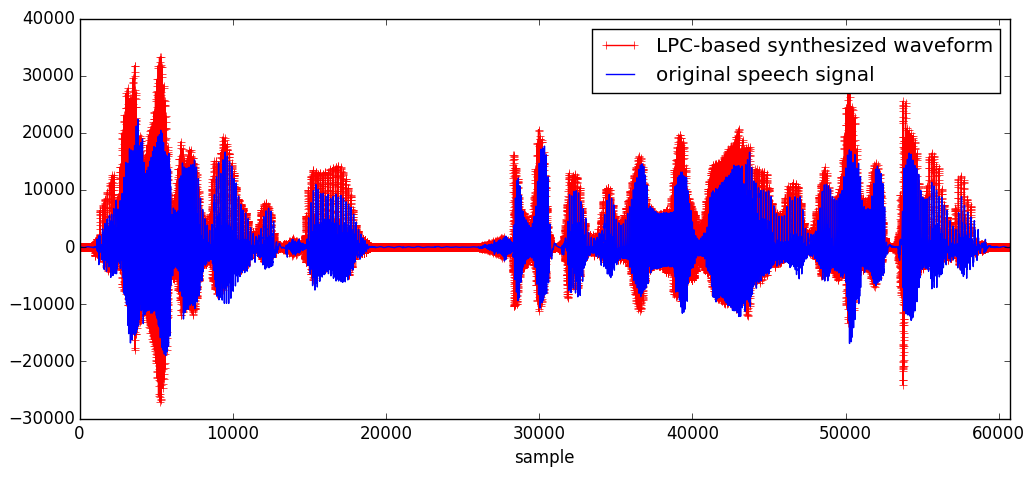

In [13]:
l = estimate(LinearPredictionCoef(25), xw, use_mgcep=true)
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="LPC-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from PARCOR

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7/AAD////////9//////8AAAMA//8BAAEAAAD+/wEAAwD//wEAAQACAAQA//8BAAEAAAD//wAA///+/wAAAAD+////AAABAAIAAwADAAUABAAFAAUAAwAEAAUAAwADAAYAAwAGAAMAAwADAAEABAAEAAMABQAGAAYABAAHAAgACQALAAoACQAJAAkACQAIAAUABAAFAAIABAADAAQABwAGAAcABgAGAAcABwAGAAUABAAEAAMAAwADAAMABAAEAAMAAwAFAAMAAgAEAAMAAwABAAEAAwADAAIAAgACAAIAAwADAAQABAADAAIAAQACAAIAAgADAAMAAAADAAMAAgAEAAQABgAJAAcABwAHAAUABgAGAAQACAAGAAQABgAGAAUABAAFAAUABAADAAUABAADAAUAAgABAAEA//////7/AAACAAIAAQADAAEAAAABAAAAAgAAAAAAAAABAAAA//8AAP//AAD/////AQABAP////8AAAEAAQACAAUABAAEAAQAAwACAAIAAgACAAIAAAABAAAA//////////8BAAIAAQAEAAIAAgABAAAAAQAAAAAAAQD///z////+//z//v8AAP///P/+//3//P/6//v/+v/6//j/9//3//f/+P/1//b/9v/3//r/+v/6//n/+f/7//n//P/6//j/+f/5//j/9//5//r/+f/7//r/+P/4//j/9//0//X/8v/z//L/8v/z//P/8//1//L/8//1//b/9P/1//P/9f/1//P/8//2//X/9f/1//b/9f/5//j/+f/3//r/+P/5//j/9//3//n/+f/5//j/+f/8//r/+v/5//v/+//6//r/+v/7//3//v/7//v/+v/7//r/+//3//j/+P/4//n/+P/5//n/+v/5//r/+P/6//r/+//6//v/+//8//j/+//4//r/+//6//n/+//4//f/+P/3//f/9v/4//j/+P/7//3//P/9//v//v/9//3//v/+//v//f/9//v/+v/6//v/+//7//v//P/7//3//P/9//3//P/9//r/9//4//z//P/7//z//f/9//v//v/9/wAAAAABAAEA//8AAAIABQAFAAcACgALAA4ADgAOABEAEQASAA8ADwASABAAEgAPAA4ADQAMAA0ADgAMAA8ADgAMAAoACgALAAsACgAJAAsACwALAAkADQAMAA0ACwALAAoADAAMAA4ADQALAA0ADwAPAA0ADQANABAADwAPAA4ADgAMAAwACwAIAAkACgAJAAgACAAJAAwACgAKAAYABQAHAAQABAACAAIAAAD+//z//v/+/wAA///9//z/+v/4//r/+P/7//3///8BAAEAAgADAAEAAgD9/wAA/v8AAP7/AAABAAIABAAEAAUAAwAFAAQABAADAAQABAADAAAAAAAAAP3///8AAAAAAQACAAIAAgADAAAA//////3/+v/6//v//f/+//7//P/8//z//f/9//z/AQAAAAAAAAD//wEA//////z//P/8//7//v8AAAEAAAD9//7/AQACAAEAAQD///7/AgAAAP//+//8//3/AQAAAAIAAgABAAMAAgACAP//AAD+///////9//f/9//0//b/9//4//b/9//5//3/AQAAAAMABwAHAAcABQACAP7//P/9//3/+//9//z///8BAAIAAQACAAEAAQD+//f/7v/q/+j/6f/s/+3/7f/w/+z/8f/x/+//6//q/+f/5P/i/+X/6P/u//b/+f8CAAUADAAHAAYAAgD+//P/7f/t/+//8f/z//L/+P8BAAcADQAOAAwABgAEAAMA///6//f/8f/v//P/9/8AAAUACgALAAwADwALAA0ABwADAAAAAwAGAA0AEgASABUADwAMAAMA///3//P/9P/1//j/+/8AAAQACAAHAAYA/P/8//T/+P/6/wAABQAMAA0AFAAXABkAGwAWAA8ADAAGAP///P/6//r/8v/5//P////5/wYAAwAIAAgAEQATAB8AHgAlAB0AFQAHAP3/8//s/+T/4f/j/+r/9f8BAA8AFQAdABUAEAADAPv/7//n/9f/0P/N/9X/5f/5/woAHgAqADMAOAA1ACoAGwAIAPL/4//f/+H/4//a/9P/1P/i/+r/AAAUACwAPwBGAEgAMQAaAPb/1P+4/6r/pv+v/8b//f8lADwAKAAFANb/u/+p/7H/xf/b/wAAHABGAGcAewBeACUAwP9e/wH/3v7c/g7/Qf+R/9f/JwBtAJoAoAB5AEsAIwArAFEAmQDOAPwACQEIAdsAlwAvANH/ef83/wf/6P73/iT/hf/1/3cAywD6APIAxwCFAE0AMwBNAIcA0wAUASQBIQHdAIUA//9v/9P+UP4F/hD+aP4K/9b/ngA6Aa4B4gHYAakBTQHWAF4A7f98/xr/0v6z/q3+uP60/pb+fv5p/mr+mP7W/hX/Rf+N/w8AxgB3AQACQAJEAikCDwIPAgEC7gHCAZIBVgEXAc0AiAAcAJr///5w/tP9YP1B/Xn9+v26/pj/mAC9AbwCQwMlA4QCiAE3ALr+L/3j++P6Xfof+jD6Zfrq+sL7w/yh/TH+s/5O/woAugB9AScCrQL2AgwD0gJAAkoBPABi/yX/fv8sAPoAuQGTAisDewM/A6QCygEVAW4A9/+f/73/dwCMAcQCuANXBGUEBgQhA/EBWwCx/kj9nPyy/C/9yf1I/r7+R/8QAPMAygEEArcB4ABGAOn/1v+u/yz/ev7e/cb9BP5s/sz+Rv+9/zwAtgBWAecBUQJdAlgCDgLaAYoBIAFkAI//3/4v/rr9Xv1O/Un9P/30/Lr84PzV/Qn/PAAEAZ0B3QEiAm4CkgJZAoQBiQA9/4f+A/4X/hD+UP5V/pT+M/8wABMBPQG6AKb/lv6p/UL9IP1u/bX9QP5//sr+xv6v/hT+ZP2h/EL82/ux+4r7Efzl/Gz+4/9TAUwCCQPIA4IEMAWTBZYFOAWpBPkDUAOZAqgBaQDr/uL9Tv1U/dP9YP7R/hT/ff8sAN0AdgHCAckBtwHuAU8C8QIxAzcD1AKXAk4C6QFOATwADv/A/br85vuD+5T7Kvw1/Xb+cv/4/yQAIgAPAKn/6v6j/S78Hfv++u/7Kf1y/mP/XgA2Ae0BCgKJAbsA5P9m//T+y/6K/rL+r/7a/vP+CP/t/qz+1/6K/3QApwG2AvYDHwU7Bg4H8AYaBsYETQPAAS0Awf60/cX8gvy0/J39Z/4K/5r/SQD4AFsBXwFwAcYBPgJRAgMCmQEIAYAAz/+q/1L/P/8d/2//X/90/0L/eP8F/+n+w/4U/1H/uP8jAIcAygAMAfUA5gBwAHEA/P/V/2X/6/45/sT9BP6g/h//Wv9p/2b/dv/K/zsAdgD7/3r/G/+E/2QA3gMLCe4OhBNSFg0YqRjyGOoXcBXJEKwLzAbPAywCIwI+An8C3gLZA2wFywbmBz8IFwiaB0sHUQe2B9oHzwfOBnEFdwPKAdj/C/7g+yP6pvhV+M/4bfoa/BX+hf/qANQBoQLjAqACwQF/ACL/9P0q/af8TPzm+4X7OPsi+3v78/uU/PP8fP0l/iP/QgA0AQsCNgJRAs8BhQHEADgAMP98/pj9Xv0h/YX97f2j/kL/v/9TANwAlgHpATcCCwIBApsBrAFTATwBlABGAKH/a/8A/xb/6/4O/xj/av/R/04A5gAqAYgBdQG0AXkBZAHhAJwAHADW/3X/Sv8T//z+/v4a/0T/eP+0/9j/FgBOAJ0AvgC7AMQAoQCNAFQALADn/57/aP8+/xj/Hv8m/2b/Z/+p/9H/HwBJA

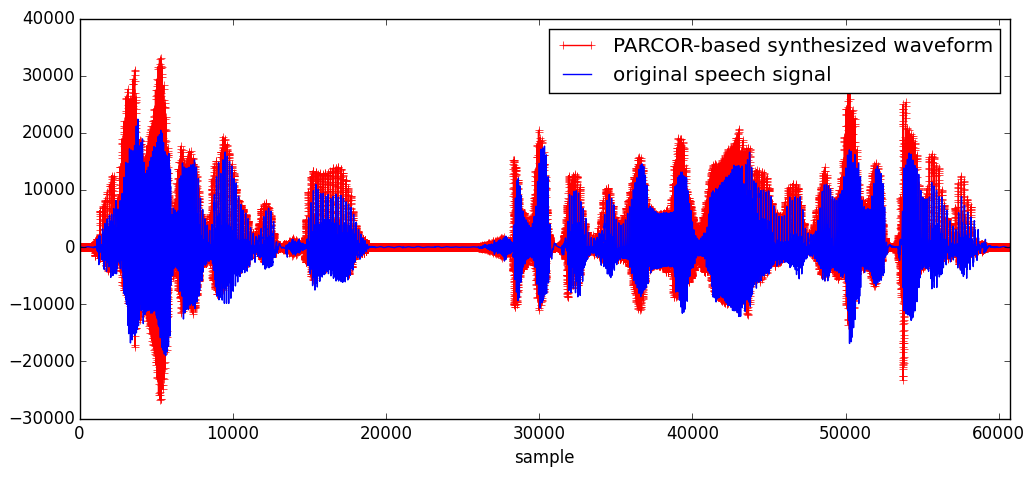

In [14]:
l = lpc2par(estimate(LinearPredictionCoef(25), xw))
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="PARCOR-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)

### Synthesis from LSP

<source src="data:audio/wav;base64,UklGRlzaAQBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YTjaAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP////8AAAAAAAABAAAA///9//7/AAD////////9/////////wMA//8AAAEAAAD//wEAAwD//wEAAgACAAQAAAABAAAAAQD//wAA///+/wAAAAD+////AAABAAEABAADAAQABAAFAAUABAAEAAYABAAEAAcABQAHAAQABAAEAAIABAAEAAQABgAGAAcABQAIAAgACQALAAsACgAKAAsACgAJAAcABQAGAAMABQAFAAQACAAHAAcABgAGAAcABwAGAAUABAAEAAMAAwADAAMAAwAEAAIAAwAEAAIAAQADAAIAAgAAAAAAAgADAAEAAQABAAEAAgACAAQAAwACAAEAAAACAAEAAQACAAMAAAADAAMAAgAEAAQABgAJAAgACAAIAAYABwAHAAUACQAHAAYACAAIAAcABgAHAAYABQAEAAYABQAEAAYAAwACAAEA//8AAP//AAACAAIAAQADAAEAAAAAAP//AQAAAAAAAAABAAAA//////7/AAD/////AQABAP////8AAAEAAQACAAUABAAEAAUAAwADAAMAAwADAAQAAgADAAIAAQABAAAAAQADAAQAAgAFAAMAAwACAAEAAgACAAEAAgAAAP7/AQD///3/AAABAAEA/f////7//f/7//v/+v/6//j/+P/3//b/+P/0//X/9f/2//n/+f/5//f/9//5//j/+//5//f/+P/5//j/9//5//r/+f/6//v/+f/4//n/9v/0//X/8//z//H/8v/z//P/8v/0//H/8v/0//X/8//0//L/9P/0//P/8v/2//T/9f/1//b/9f/5//j/+f/4//v/+P/6//j/+P/4//r/+v/7//r/+v/9//v//P/7//z//f/7//z//P/8//7////8//3//P/8//v//f/5//n/+f/5//r/+f/6//n/+//6//r/+f/6//r//P/6//v//P/8//n/+//4//r/+//6//r//P/4//j/+P/3//f/9v/4//f/+P/7//z/+//8//r//v/9//3//v/+//v//v/+//z/+v/6//z/+//8//v//P/7//3//P/8//3//P/9//r/+P/4//z//P/7//z//f/9//v////9/wAAAAABAAIA//8BAAIABQAGAAkACwAMAA8AEAAQABIAFAAUABIAEgAVABMAFQASABIAEAAPABAAEAAOABEADwANAAsACwALAAsACgAJAAoACgAJAAgACwAKAAsACQAIAAkACQAKAAsACgAJAAoADAAMAAsACgALAAwADQAMAAwACwAJAAkACAAFAAcABgAGAAUABQAGAAgABgAGAAMAAQADAP//AAD+//3//P/6//j/+v/6//v/+//5//j/9f/z//X/8//3//j/+//9//7///8AAP7/AAD7/////f////7/AAAAAAEAAwADAAUAAgAFAAQABAADAAQABAACAAAA/v////z//v//////AQABAAEAAQACAP///f/9//z/+P/4//n/+//8//3/+//6//v//P/7//v/AAD//////////wAA/v/+//z//f/+/wAAAAACAAIAAQD+//7/AQACAAIAAQD///7/AgABAAAA+//8//3/AQABAAMAAgABAAMAAQACAP//AAD9//7//v/9//f/9//z//T/9v/3//X/9f/2//r//v/+/wAABAAFAAYABgADAAAA/v8AAAAA//8CAAIABAAEAAUAAwADAAMAAgD9//b/7f/n/+T/5f/o/+n/6v/u/+n/7v/u/+z/6P/n/+T/4f/f/+H/5P/q//P/+P8EAAkAEgAPAA8ADAAIAP7/+P/1//f/9//5//f//f8GAAwAFAAWABQADQALAAgAAwD7//b/7v/q/+7/8//+/wUADAAOABAAFAAQABEACAABAPv//f8AAAcACwANABIADgAOAAgABwD+//n/+P/3//X/8//0//T/9//3//r/9P/4//T/+v/9/wMABgALAAoADgAQABQAGAAXABQAFQAQAAgAAwD///r/7//0/+3/+f/z/wEA//8IAAkAEwAUACEAHQAjABkAEQAAAPf/7//r/+b/6P/v//v/BwAUAB8AIgAkABgADwD///T/5f/c/83/xv/E/8//4P/5/w8AKwA9AEwAUgBSAEQAMAAUAPf/3v/S/87/zv/G/8D/xP/Y/+n/CgApAEsAYgBpAGUAQwAeAOf/tf+N/3z/ev+O/7L/+f8yAF0AVgA1APr/zf+o/6P/sf/E/+T/+/8iAEUAZABZADIA1/95/xr/8/7q/hX/QP+G/77/BwBNAIoArgCrAJ8AkQCrANsAJAFPAWgBUAEiAckAYgDn/4b/O/8M//X+7v4O/z7/l//2/2cAsQDeANgAsQByAEIAPAByAM8AOgGNAZ8BiwEnAaoA/v9U/6b+HP7R/eL9Rf74/tb/rQBSAcQB8wHiAbEBXAHvAIMAHACy/0v/+/7O/rn+uP6y/pb+hv55/oD+rv7o/iH/Rf+A//D/mABAAdQBKgJWAmICbgKHAogCdwI+AvQBjQEZAZIAGACD/+z+Tv7P/VD9BP0K/WP9//3W/sr/4AAVAh0DogN8A9MC1QGBAAT/c/0g/BP7ifpE+k/6dfrs+rT7rfyL/SL+rv5V/xwAygCHAS4CwAIaA0MDFwOLApQBggCn/1//ov8nAL8AOwHFAQcCDgKrARQBaQALANT/1P/o/1kASwF1AqoDgwT7BN4EWARKA+wBLQBj/u/8Q/xk/Of8hv0J/pH+L/8WACMBMQKiAnMCmgHWADsA4f+K//j+Wv7k/QH+ef4Z/5//IQB6ALcA1AAEAS0BPQEWAQYB7AAUAUEBVAH9AGYAyv8Z/5H+Ef69/WL9/vxy/Bf8Qvxd/cv+NwA2AfoBTgKMAr8CwQJiAn0BiwBf/8H+TP5f/lH+h/6A/qX+F//f/4gAdQDK/67+tv3x/Mj88/yb/Uj+OP/L/zkAIgC//8H+sP2u/DD8wPuJ+z77lftA/M39eP9BAYcCfANJBBEFzgVQBl0G7QUYBQYE+gIBAvMApP8X/v38ZfyC/Cv96f1n/oz+uv4t/7r/UwC5APEAHgGoAXcCjAM6BIEEMATrA44DGANjAiYBp//0/Y/8dfvg+s36Qfsz/H39n/5l/7//yv+j/y//iv5+/VX8dftt+2381v1y/8wAFwIPA6kDhgO1ApYBcgCb/9n+WP7C/ZT9T/1Q/Xj93v03/nX+D/8pAGYB1gLwA/AElAUFBj4GrAWjBD8D4QGLAEz/T/6s/Q393/zr/J39Jv6K/uX+bP8IAGAAeACpABwBqgHMAY8BPQG4AFYA3/8fAE8A2gBQAfgB8AHBARoBqQB3/6H+5P3M/eH9R/7g/o7/RwACAWoB1gHKAQgCzgG9AVQBnACj/8f+pP7y/lP/l/+g/5X/iv/C/ygAagAFAHb/AP9Q/yoA5wPFCXcQ0xUtGQYbRhvuGk4ZZRaJERAMqQbkAmYArP9d/57/DgAtAQQD5QSABkYHaAcKB5kGUQZiBiwGFAaABV0FCwVfBWUFZQWxBBQEQwPhAlwCOgLGAaABXQGJAdABRAKlAuECDgMPAxgDBgP+Ar4CgwIoAusBpAF9AXgBcAFxAUoBPwE+AVYBaAFIAU8BGAEwAQgBNAEbATkBBwEjAQMBNgEJARgB7ADvAOAAugCtAJEAsgCOAKAAdwCYAGUArQCEALgAbgCmAHkAqgBwAJwAagB8AFwAaABpAGUAeABEAF8AKQByAE4AcwAiADYAEgBJADwAZABAADkAHgAzAD8AVABTACwAHAARAEQAWwBrAHEAYgBVAFYAYgB1AFsAVgAtABIADwATADoAFgAaAAAAFQAcA

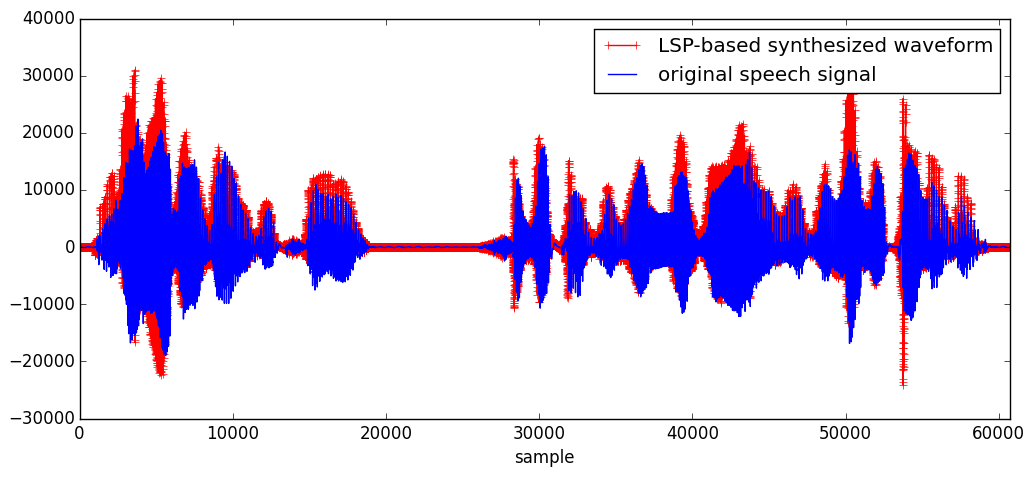

In [15]:
l = lpc2lsp(estimate(LinearPredictionCoef(15), xw))
y = synthesis(base_excitation, l, hopsize)
wavcompare(x, y, label="LSP-based synthesized waveform")
inline_audioplayer(round(Int16, clamp(y, typemin(Int16), typemax(Int16))), fs)